In [ ]:
!pip install 'git+https://github.com/facebookresearch/detectron2.git'


  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-pu3e2btz
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-pu3e2btz
  Resolved https://github.com/facebookresearch/detectron2.git to commit c69939aa85460e8135f40bce908a6cddaa73065f
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.2/79.2 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 9.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 79.8 MB/s eta 0:00:00
  Created wheel for detectron2: filename=detectron2-0.6-cp31

In [ ]:
import os
import cv2
import json
import numpy as np
from pycocotools import mask
from PIL import Image
from sklearn.model_selection import train_test_split

# Paths
image_dir = "/content/drive/MyDrive/imss/Image/"
mask_dir = "/content/drive/MyDrive/imss/Mask/"
output_dir = "/content/coco_dataset"
os.makedirs(output_dir, exist_ok=True)

# Split dataset into train and val
images = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir)])
masks = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir)])

train_images, val_images, train_masks, val_masks = train_test_split(images, masks, test_size=0.2, random_state=42)

def create_coco_json(images, masks, output_path):
    coco_data = {
        "images": [],
        "annotations": [],
        "categories": [{"id": 0, "name": "flood"}],
    }
    annotation_id = 0

    for idx, (img_path, mask_path) in enumerate(zip(images, masks)):
        # Image info
        img = Image.open(img_path)
        img_width, img_height = img.size
        image_info = {"id": idx, "file_name": os.path.basename(img_path), "height": img_height, "width": img_width}
        coco_data["images"].append(image_info)

        # Mask info
        mask_image = np.array(Image.open(mask_path).convert("L"))
        contours, _ = cv2.findContours(mask_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        for contour in contours:
            if cv2.contourArea(contour) > 0:
                segmentation = contour.flatten().tolist()
                annotation = {
                    "id": annotation_id,
                    "image_id": idx,
                    "category_id": 0,
                    "segmentation": [segmentation],
                    "area": cv2.contourArea(contour),
                    "bbox": cv2.boundingRect(contour),
                    "iscrowd": 0,
                }
                coco_data["annotations"].append(annotation)
                annotation_id += 1

    with open(output_path, "w") as f:
        json.dump(coco_data, f)
    print(f"COCO JSON created at {output_path}")

# Generate train and val JSONs
create_coco_json(train_images, train_masks, os.path.join(output_dir, "train.json"))
create_coco_json(val_images, val_masks, os.path.join(output_dir, "val.json"))


COCO JSON created at /content/coco_dataset/train.json
COCO JSON created at /content/coco_dataset/val.json


In [ ]:
import detectron2
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.data.datasets import register_coco_instances

# Register COCO datasets
register_coco_instances("flood_train", {}, "/content/coco_dataset/train.json", image_dir)
register_coco_instances("flood_val", {}, "/content/coco_dataset/val.json", image_dir)

# Configure Mask R-CNN
cfg = get_cfg()
cfg.merge_from_file("detectron2/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.DATASETS.TRAIN = ("flood_train",)
cfg.DATASETS.TEST = ("flood_val",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 1000  # Adjust for larger datasets
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # Only one class: flood
cfg.OUTPUT_DIR = "./output"

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()


AssertionError: Config file 'detectron2/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml' does not exist!

In [ ]:
import os
import detectron2
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.data.datasets import register_coco_instances

# Download the Mask R-CNN config
!mkdir -p detectron2_configs/COCO-InstanceSegmentation
!wget https://raw.githubusercontent.com/facebookresearch/detectron2/main/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml -O detectron2_configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml

# Register COCO datasets
image_dir = "/content/drive/MyDrive/imss/Image/"
register_coco_instances("flood_train", {}, "/content/coco_dataset/train.json", image_dir)
register_coco_instances("flood_val", {}, "/content/coco_dataset/val.json", image_dir)

# Configure Mask R-CNN
cfg = get_cfg()
cfg.merge_from_file("detectron2_configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.DATASETS.TRAIN = ("flood_train",)
cfg.DATASETS.TEST = ("flood_val",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 1000  # Adjust for larger datasets
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # Only one class: flood
cfg.OUTPUT_DIR = "./output"

# Create output directory and train
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()


--2024-12-16 00:01:31--  https://raw.githubusercontent.com/facebookresearch/detectron2/main/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 192 [text/plain]
Saving to: ‘detectron2_configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml’

detectron2_configs/ 100%[===================>]     192  --.-KB/s    in 0s      

2024-12-16 00:01:32 (13.1 MB/s) - ‘detectron2_configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml’ saved [192/192]



FileNotFoundError: [Errno 2] No such file or directory: 'detectron2_configs/Base-RCNN-FPN.yaml'

In [ ]:
!mkdir -p detectron2_configs/COCO-InstanceSegmentation
!wget https://raw.githubusercontent.com/facebookresearch/detectron2/main/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml -O detectron2_configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml


--2024-12-16 00:01:49--  https://raw.githubusercontent.com/facebookresearch/detectron2/main/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 192 [text/plain]
Saving to: ‘detectron2_configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml’

detectron2_configs/ 100%[===================>]     192  --.-KB/s    in 0s      

2024-12-16 00:01:49 (6.63 MB/s) - ‘detectron2_configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml’ saved [192/192]



In [ ]:
cfg.merge_from_file("detectron2_configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")


FileNotFoundError: [Errno 2] No such file or directory: 'detectron2_configs/Base-RCNN-FPN.yaml'

In [ ]:
# Create the base directory for configs
!mkdir -p detectron2_configs/Base

# Download the base configuration file
!wget https://raw.githubusercontent.com/facebookresearch/detectron2/main/configs/Base-RCNN-FPN.yaml -O detectron2_configs/Base/Base-RCNN-FPN.yaml


--2024-12-16 00:03:07--  https://raw.githubusercontent.com/facebookresearch/detectron2/main/configs/Base-RCNN-FPN.yaml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1318 (1.3K) [text/plain]
Saving to: ‘detectron2_configs/Base/Base-RCNN-FPN.yaml’

detectron2_configs/ 100%[===================>]   1.29K  --.-KB/s    in 0s      

2024-12-16 00:03:07 (100 MB/s) - ‘detectron2_configs/Base/Base-RCNN-FPN.yaml’ saved [1318/1318]



In [ ]:
!ls detectron2_configs/Base
!ls detectron2_configs/COCO-InstanceSegmentation


Base-RCNN-FPN.yaml
mask_rcnn_R_50_FPN_3x.yaml


In [ ]:
cfg.merge_from_file("detectron2_configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")


FileNotFoundError: [Errno 2] No such file or directory: 'detectron2_configs/Base-RCNN-FPN.yaml'

In [ ]:
with open("detectron2_configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml", "r") as file:
    config = file.read()

# Replace the reference path for Base-RCNN-FPN.yaml
config = config.replace("../Base-RCNN-FPN.yaml", "detectron2_configs/Base/Base-RCNN-FPN.yaml")

# Save the updated config file
with open("detectron2_configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml", "w") as file:
    file.write(config)
print("Updated config paths successfully!")


Updated config paths successfully!


In [ ]:
cfg.merge_from_file("detectron2_configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")


FileNotFoundError: [Errno 2] No such file or directory: 'detectron2_configs/COCO-InstanceSegmentation/detectron2_configs/Base/Base-RCNN-FPN.yaml'

In [ ]:
import os
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.data.datasets import register_coco_instances

# Register COCO datasets
image_dir = "/content/drive/MyDrive/imss/Image/"
register_coco_instances("flood_train", {}, "/content/coco_dataset/train.json", image_dir)
register_coco_instances("flood_val", {}, "/content/coco_dataset/val.json", image_dir)

# Configure Mask R-CNN
cfg = get_cfg()
cfg.merge_from_file("detectron2_configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.DATASETS.TRAIN = ("flood_train",)
cfg.DATASETS.TEST = ("flood_val",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 1000  # Increase for larger datasets
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # Single class: flood
cfg.OUTPUT_DIR = "./output"

# Train the model
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()


FileNotFoundError: [Errno 2] No such file or directory: 'detectron2_configs/COCO-InstanceSegmentation/detectron2_configs/Base/Base-RCNN-FPN.yaml'

In [ ]:
!cat detectron2_configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml


_BASE_: "detectron2_configs/Base/Base-RCNN-FPN.yaml"
MODEL:
  WEIGHTS: "detectron2://ImageNetPretrained/MSRA/R-50.pkl"
  MASK_ON: True
  RESNETS:
    DEPTH: 50
SOLVER:
  STEPS: (210000, 250000)
  MAX_ITER: 270000


In [ ]:
!ls detectron2_configs/Base


Base-RCNN-FPN.yaml


In [ ]:
_BASE_: "../Base/Base-RCNN-FPN.yaml"


In [ ]:
import os

base_path = "detectron2_configs/Base/Base-RCNN-FPN.yaml"
if os.path.exists(base_path):
    print(f"{base_path} is accessible.")
else:
    print(f"{base_path} is NOT accessible.")


detectron2_configs/Base/Base-RCNN-FPN.yaml is accessible.


In [ ]:
!cat detectron2_configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml


_BASE_: "detectron2_configs/Base/Base-RCNN-FPN.yaml"
MODEL:
  WEIGHTS: "detectron2://ImageNetPretrained/MSRA/R-50.pkl"
  MASK_ON: True
  RESNETS:
    DEPTH: 50
SOLVER:
  STEPS: (210000, 250000)
  MAX_ITER: 270000


In [ ]:
import os
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.data.datasets import register_coco_instances

# Register the COCO-format dataset
image_dir = "/content/drive/MyDrive/imss/Image/"
register_coco_instances("flood_train", {}, "/content/coco_dataset/train.json", image_dir)
register_coco_instances("flood_val", {}, "/content/coco_dataset/val.json", image_dir)

# Configure Mask R-CNN
cfg = get_cfg()
cfg.merge_from_file("detectron2_configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.DATASETS.TRAIN = ("flood_train",)
cfg.DATASETS.TEST = ("flood_val",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 1000  # Adjust for larger datasets
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # Single class: flood
cfg.OUTPUT_DIR = "./output"

# Train the model
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()


FileNotFoundError: [Errno 2] No such file or directory: 'detectron2_configs/COCO-InstanceSegmentation/detectron2_configs/Base/Base-RCNN-FPN.yaml'

In [ ]:
_BASE_: "../Base-RCNN-FPN.yaml"


In [ ]:
# Open the config file and update the _BASE_ path
with open("detectron2_configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml", "r") as file:
    config = file.read()

# Update _BASE_ path to remove redundancy
config = config.replace(
    "detectron2_configs/Base/Base-RCNN-FPN.yaml",
    "../Base-RCNN-FPN.yaml"
)

# Save the corrected config file
with open("detectron2_configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml", "w") as file:
    file.write(config)

print("Updated _BASE_ path in mask_rcnn_R_50_FPN_3x.yaml")


Updated _BASE_ path in mask_rcnn_R_50_FPN_3x.yaml


In [ ]:
import os

base_path = "detectron2_configs/Base-RCNN-FPN.yaml"
if os.path.exists(base_path):
    print(f"{base_path} is accessible.")
else:
    print(f"{base_path} is NOT accessible.")


detectron2_configs/Base-RCNN-FPN.yaml is NOT accessible.


In [ ]:
_BASE_: "../Base/Base-RCNN-FPN.yaml"


In [ ]:
# Correct _BASE_ path
with open("detectron2_configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml", "r") as file:
    config = file.read()

# Update _BASE_ to include the correct subdirectory
config = config.replace(
    "../Base-RCNN-FPN.yaml",
    "../Base/Base-RCNN-FPN.yaml"
)

# Save the corrected config file
with open("detectron2_configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml", "w") as file:
    file.write(config)

print("Updated _BASE_ path successfully!")


Updated _BASE_ path successfully!


In [ ]:
import os

base_path = "detectron2_configs/Base/Base-RCNN-FPN.yaml"
if os.path.exists(base_path):
    print(f"{base_path} is accessible.")
else:
    print(f"{base_path} is NOT accessible.")


detectron2_configs/Base/Base-RCNN-FPN.yaml is accessible.


In [ ]:
cfg.merge_from_file("detectron2_configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")


In [ ]:
import os
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.data.datasets import register_coco_instances

# Register the COCO-format dataset
image_dir = "/content/drive/MyDrive/imss/Image/"
register_coco_instances("flood_train", {}, "/content/coco_dataset/train.json", image_dir)
register_coco_instances("flood_val", {}, "/content/coco_dataset/val.json", image_dir)

# Configure Mask R-CNN
cfg = get_cfg()
cfg.merge_from_file("detectron2_configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.DATASETS.TRAIN = ("flood_train",)
cfg.DATASETS.TEST = ("flood_val",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 1000  # Adjust for larger datasets
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # Single class: flood
cfg.OUTPUT_DIR = "./output"

# Train the model
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()


[12/16 00:15:38 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:00, 240MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[12/16 00:15:39 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[12/16 00:15:54 d2.utils.events]:  eta: 0:08:06  iter: 19  total_loss: 3.892  loss_cls: 0.6737  loss_box_reg: 0.1988  loss_mask: 0.6932  loss_rpn_cls: 1.66  loss_rpn_loc: 0.6511    time: 0.5055  last_time: 0.5272  data_time: 0.0517  last_data_time: 0.0194   lr: 4.9953e-06  max_mem: 2665M
[12/16 00:16:08 d2.utils.events]:  eta: 0:07:41  iter: 39  total_loss: 2.769  loss_cls: 0.6301  loss_box_reg: 0.1144  loss_mask: 0.6937  loss_rpn_cls: 0.8792  loss_rpn_loc: 0.249    time: 0.4940  last_time: 0.4694  data_time: 0.0217  last_data_time: 0.0042   lr: 9.9902e-06  max_mem: 2669M
[12/16 00:16:18 d2.utils.events]:  eta: 0:07:44  iter: 59  total_loss: 2.766  loss_cls: 0.556  loss_box_reg: 0.1481  loss_mask: 0.6928  loss_rpn_cls: 0.8833  loss_rpn_loc: 0.5615    time: 0.4965  last_time: 0.4556  data_time: 0.0336  last_data_time: 0.0154   lr: 1.4985e-05  max_mem: 2669M
[12/16 00:16:29 d2.utils.events]:  eta: 0:07:34  iter: 79  total_loss: 3.127  loss_cls: 0.459  loss_box_reg: 0.1312  loss_mask: 0.6

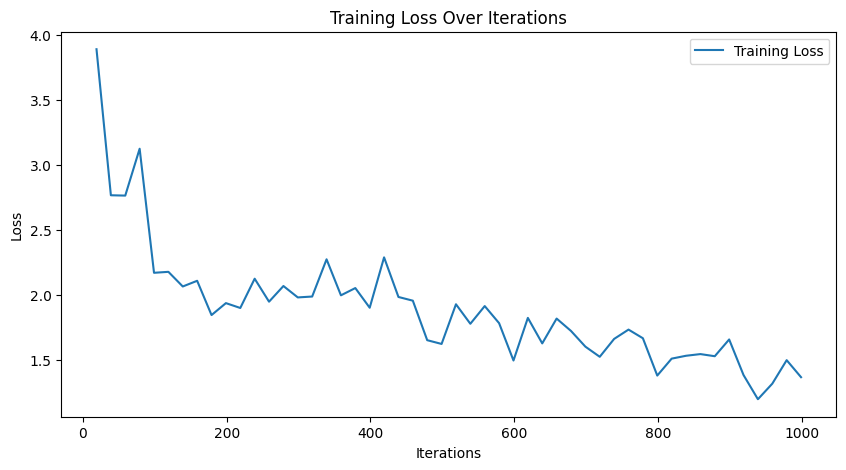

In [ ]:
import json
import matplotlib.pyplot as plt

# Path to metrics.json
metrics_path = "./output/metrics.json"

# Load metrics
with open(metrics_path, "r") as file:
    metrics = [json.loads(line) for line in file]

# Extract training losses and validation AP
iterations = [x["iteration"] for x in metrics if "iteration" in x]
losses = [x["total_loss"] for x in metrics if "total_loss" in x]
ap_50 = [x["bbox/AP50"] for x in metrics if "bbox/AP50" in x]
ap_75 = [x["bbox/AP75"] for x in metrics if "bbox/AP75" in x]

# Plot Training Loss
plt.figure(figsize=(10, 5))
plt.plot(iterations, losses, label="Training Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Training Loss Over Iterations")
plt.legend()
plt.show()


